# 10 - Count Model Data

These notes come from my reading of Washington - Statistical and Econometric Methods for Transportation Data Chapter 10.  Additional annotations throughout, but purely speculative stuff is in *italics*.  Code is my own.

In [1]:
# Preamble.
import os
import numpy as np
import pandas as pd
import scipy.stats as sps
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Default mpl colours.
prop_cycle = plt.rcParams['axes.prop_cycle']
mpl_def_colors = prop_cycle.by_key()['color']

## 10.1 - Poisson Regression

### Definition

Poisson PDF:

$$
P(y_i) = \frac{\exp{(-\lambda_i)}\lambda_i^{y_i}}{y_i!}
$$

which is eg. the probability of of intersection $i$ having $y_i$ collisions per year. $\lambda_i$ is the **Poisson parameter**, and is the expected number of events:

$$
E[y_i] = \lambda_i
$$

Models parameterize $\lambda_i$, usually using the log-linear model:

$$
\lambda_i = \exp{(\vec{\beta}\cdot\vec{X}_i)}
$$

This also means $E[y_i] = \exp{(\vec{\beta}\cdot\vec{X}_i)}$, so the parameterization sets the expected rate.

### MLE Optimization

To optimize for $\vec{\beta}$, use the standard log-likelihood formulation:

\begin{eqnarray}
L(\vec{\beta}) &=& \prod_i \frac{\exp{(\exp{(\vec{\beta}\cdot\vec{X}_i)})}\exp{(\vec{\beta}\cdot\vec{X}_i)}^{y_i}}{y_i!} \\
\ln(L) &=& \sum_i \left(-\exp{(\vec{\beta}\cdot\vec{X}_i)} + y_i \vec{\beta}\cdot\vec{X}_i - \ln(y_i!) \right)
\end{eqnarray}

### Elasticity

Once a model is fit, we can calculate *elasticities*, estimates of impact of a single exogenous variable $x_{k}$ for observation $i$:

$$
E_{x_{ik}}^{\lambda_i} = \frac{x_{ik}}{\lambda_i}\partial_{x_{ik}}\lambda_i = \beta_k x_{ik}
$$

Note the elasticity is definitionally different for different observations, since it's defined as a fixed fractional increase of the exogenous variable.

For ordinal variables, the partial derivative $\partial_{x_{ik}}\lambda_i$ is undefined, so we instead use the pseudo-elasticity

$$
E_{x_{ik}}^{\lambda_i} = \frac{\exp(\beta_k) - 1)}{\exp(\beta_k)}
$$

## 10.2 - Poisson Goodness-of-Fit Tests

### Likelihood Ratio

Generally useful test (see [here](https://rnowling.github.io/machine/learning/2017/10/07/likelihood-ratio-test.html) for logistic regression version), which tests the likelihood of a set of model weights $\vec{\beta}_U$ (U for "unrestricted") against a "reduced model" $\vec{\beta}_R$ with fewer model parameters (or equivalently most or all weights set to zero).

$$
X^2 = -2\left( \ln(L(\vec{\beta}_R)) - \ln(L(\vec{\beta}_U)\right)
$$

The `-2` comes from [Wilks's theorem](https://en.wikipedia.org/wiki/Wilks%27_theorem), and makes it so that $X^2$ is Chi-square distributed with degree of freedom equal to the difference between the number of free parameters in the restricted vs. unrestricted models.  This method can thus be used for hypothesis testing on why

See also the [Pearson and deviance statistics](https://online.stat.psu.edu/stat501/lesson/15/15.4), which are also Chi-square distributed.

The sum of model deviances $G^2$ is equal to zero for a model with perfect fit, but since predicted expected value $\hat{\lambda}_i$ is continuous but counts are not, a perfect fit is impossible.

$$
G^2 = 2\sum_i y_i \ln\left(\frac{y_i}{\hat{\lambda}_i}\right)
$$

*I figure this might be more useful in the signal-dominated high $\lambda$ regime. Recall that for large $\lambda$ we can approximate the Poisson as a Gaussian with mean $\lambda$ and standard deviation $\sqrt{\lambda}$, so some Poisson regression scenarios may have high signal-to-noise.*

An equivalent to [**coefficient of determination**](https://en.wikipedia.org/wiki/Coefficient_of_determination) $R^2$ doesn't exist because the conditional mean is nonlinear and regression is heteroscedastic.  An equivalent measure is

$$
R_p^2 = 1 - \frac{\sum_i \left((y_i - \hat{\lambda}_i) / \sqrt{\hat{\lambda}_i}\right)^2}{\sum_i \left((y_i - \bar{y}) / \sqrt{\bar{y}}\right)^2}
$$

The $\rho^2$ statistic, $\rho^2 = 1 - \ln{(L(\vec{\beta}))} / \ln{(L(\vec{\beta}))}$, is another way to measure fit error.  Under ideal circumstances, every outcome is perfectly predicted, leading to $\ln{(L(\vec{\beta}))} = 0$.

$G^2$, $R_p^2$ are only meaningful when compared to scores for other models.

## 10.3 - Right-Truncated Poisson Regression

For cases where the exogenous variable is bounded, i.e. $y_i \in [0, y_\mathrm{max}]$, we can modify the Poisson distribution by capping it at $y_\mathrm{max}$ and replacing the normalization coefficient $\exp{(-\lambda_i)}$ with $\sum_0^{y_\mathrm{max}} 
\lambda_i^{y_i} / y_i!$.

## 10.4 - Negative Binomial Regression

The Poisson RV's variance is fixed to its mean, a property often not seen in empirical distributions.  In practice if $E[y_i] > Var[y_i]$, the distribution is *overdispersed*; if $E[y_i] < Var[y_i]$ it is *underdispersed*. This is often because variables influencing the Poisson rate are omitted from the regression.

The negative binomial model replaces $\lambda_i = \exp{(\vec{\beta}\cdot\vec{X}_i)}$ with

$$
\exp{(\vec{\beta}\cdot\vec{X}_i + \epsilon_i)}
$$

where $\exp{(\epsilon_i)}$ is a [Gamma-distributed RV](https://en.wikipedia.org/wiki/Gamma_distribution).  This means

$$
Var[y_i] = E[y_i] + \alpha E[y_i]^2
$$

and as $\alpha \rightarrow 0$, the distribution tends toward a Poisson one (see discussion in alternate formulation).

The functional form is

$$
P(y_i) = \frac{\Gamma((1/\alpha) + y_i)}{\Gamma(1/\alpha)y_i!}\left(\frac{1/\alpha}{(1/\alpha) + \lambda_i}\right)^{1/\alpha}\left(\frac{\lambda_i}{(1/\alpha) + \lambda_i}\right)^{y_i}
$$

where $\Gamma$ is the [Gamma function](https://en.wikipedia.org/wiki/Gamma_function).  The corresponding likelihood function is

$$
L(\lambda_i) = \prod_i \frac{\Gamma((1/\alpha) + y_i)}{\Gamma(1/\alpha)y_i!}\left(\frac{1/\alpha}{(1/\alpha) + \lambda_i}\right)^{1/\alpha}\left(\frac{\lambda_i}{(1/\alpha) + \lambda_i}\right)^{y_i}
$$

A **test for overdispersion** (Cameron and Trivedi 1990) assumes:

\begin{eqnarray}
H_0: Var[y_i] &=& E[y_i] \\
H_A: Var[y_i] &=& E[y_i] + \alpha g(E[y_i])
\end{eqnarray}

where (typically) $g(f) = f$ or $g(f) = f^2$.  To conduct the test, create variables

\begin{eqnarray}
Z_i &=& \frac{(y_i - E[y_i])^2 - y_i}{E[y_i]\sqrt{2}} \\
W_i &=& \frac{g(E[y_i])}{\sqrt{2}}
\end{eqnarray}

then run the regression $Z_i = aW_i$, and check if $a$ is statistically significant in either case for $g(f)$.  If it is, then $H_0$ is rejected for the associated $g$.

### *Alternate Formulation*

*Here's an alternate formulation of the negative binomial distribution - given a Bernoulli experiment with success probability $p$, the negative binomial distribution is the PMF for the number of failed independent trials required to accumulate $r$ successes (eg. the number of tail coin-flips needed to obtain 3 heads is negative binomial distributed with $p = 0.5$ and $r = 3$).  The lower bound is zero (since we need at least $r$ trials for $r$ successes).*

*Scipy's [docs](https://docs.scipy.org/doc/scipy/reference/tutorial/stats/discrete_nbinom.html) and [Wikipedia](https://en.wikipedia.org/wiki/Negative_binomial_distribution) define the PMF as (note the Wikipedia article has notation errors in the PMF):*

$$
f(k|p, r) = {k + r - 1 \choose k}p^r(1 -  p)^k,\,\,k = 0, 1, 2,...
$$

*This can be [reformulated](https://en.wikipedia.org/wiki/Negative_binomial_distribution) as the equation above:*

$$
f(k|p, r) = \frac{\Gamma(k + r)}{k!\Gamma(r)}p^r(1 - p)^k
$$

*Here $k = y_i$, $r = 1 / \alpha$ and $p = r / (r + \lambda_i)$.  Recall that the binomial RV [approaches the Poisson one](https://en.wikipedia.org/wiki/Poisson_limit_theorem) if $p \rightarrow 0$ and $n \rightarrow \infty$ such that $n p \rightarrow \lambda_i$.  Here we make a similar formulation by noting that the PMF can be rewritten as:*

$$
f(k|p, r) = \frac{r}{k + r}{k + r \choose k}p^r(1 -  p)^k,\,\,k = 0, 1, 2,...
$$

*Now, take $r = 1 / \alpha \rightarrow \infty$, and $p \rightarrow 0$ such that $(k + r)p \rightarrow \lambda$ ($k$ doesn't matter here since $kp \rightarrow 0$).  Given these conditions $r / (k + r) \rightarrow 1$, so when $r$ goes to infinity we approach the Poisson distribution.*

*The mean on Wikipedia is inverted (because their $p$ is the probability of failure, not success); converting to our notation, we get*

$$
\mu = r\frac{1-p}{p}
$$

*See also [here](https://www.sciencedirect.com/topics/mathematics/negative-binomial-distribution) for confirmation.*

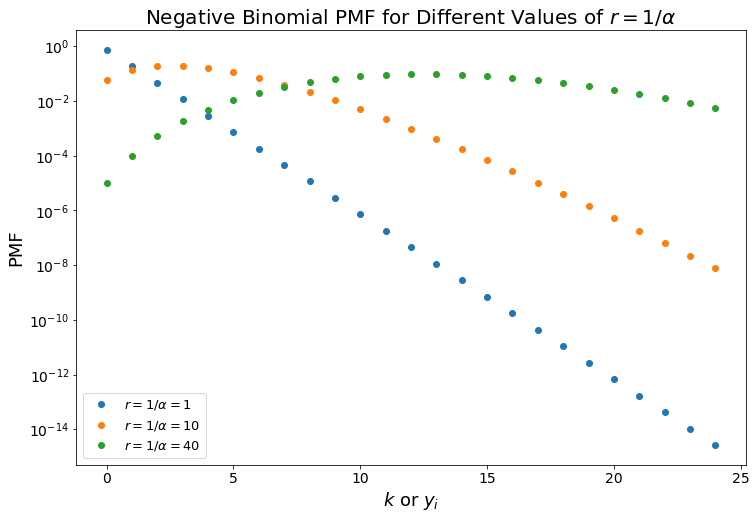

In [2]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.semilogy(sps.nbinom.pmf(np.arange(25), 1, 0.75), marker='o', ls='None', label=r'$r= 1/ \alpha =1$')
ax.semilogy(sps.nbinom.pmf(np.arange(25), 10, 0.75), marker='o', ls='None', label=r'$r= 1/ \alpha=10$')
ax.semilogy(sps.nbinom.pmf(np.arange(25), 40, 0.75), marker='o', ls='None', label=r'$r= 1/ \alpha=40$')
ax.set_xlabel('$k$ or $y_i$', fontsize=18)
ax.set_ylabel('PMF', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(loc=3, prop={'size': 13})
ax.set_title(r"Negative Binomial PMF for Different Values of $r = 1 / \alpha$", fontsize=20);

### *Full Derivation from Hilbe*

*I was confused whether $\lambda_i$ in Washington Sec. 10.4 is fixed or random. To solve that, I turned to [Hilbe](https://www.cambridge.org/core/books/negative-binomial-regression/12D6281A46B9A980DC6021080C9419E7) Sec. 8.2.1. In the book's introduction (Sec 1.1), Hilbe notes that the NB model has multiple derivations and variants, and focuses on the common NB2 model (the default of the Statsmodels version) - this is where the variance is $\mu + \mu^2/\nu$, where $\mu$ is the Poisson variance and $\mu^2/\nu$ the Gamma variance. Typically $1/\nu = \alpha$, the typical formulation in statistical software packages.*

*The negative binomial PDF is*

$$
f(y|\lambda, u) = \frac{\exp(-\lambda_i u_i)(\lambda_i u_i)^{y_i}}{y_i!}
$$

*The conditional mean $E[y|\lambda, u]$ (i.e. the mean given fixed $\lambda$, $\mu$) is $\lambda u$ (since $f$ has a Poisson form). The unconditional distribution for $y$ can be found by integration:*

$$
f(y|x, u) = \int_0^\infty \frac{\exp(-\lambda_i u_i)(\lambda_i u_i)^{y_i}}{y_i!}g(u_i) d u_i
$$

*Assign $\lambda_i = \exp(\vec{\beta}\cdot\vec{X}_i)$ and $u = \exp{\epsilon} \sim \mathrm{Gamma}(\nu, \eta)$, and give the [gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution) a mean of 1, so $\nu = \eta$. This gives*

$$
g(u_i) = \frac{\nu^\nu}{\Gamma(\nu)}u_i^{\nu -1}\exp(-\nu u_i)
$$

*Plugging this in, and doing a bunch of algebra (Eqns. 8.3 - 8.5 of Hilbe) gives us*

\begin{eqnarray}
f(y|\lambda, \alpha) &=& \frac{\Gamma(y_i + 1/\alpha)}{\Gamma(y_i + 1)\Gamma(1/\alpha)} \left(\frac{1}{1 + \alpha\lambda_i}\right)^{1/\alpha}\left(1 - \frac{1}{1 + \alpha\lambda_i}\right)^{y_i}\\
&=& \frac{\Gamma(y_i + 1/\alpha)}{y_i!\Gamma(1/\alpha)} \left(\frac{1}{1 + \alpha\lambda_i}\right)^{1/\alpha}\left(1 - \frac{1}{1 + \alpha\lambda_i}\right)^{y_i}
\end{eqnarray}

*Here we [use the fact that](https://en.wikipedia.org/wiki/Gamma_function#Main_definition) $\Gamma(x) = (x-1)!$ Examining this shows it's the same form as that from Washington (above).* We also define NB overdispersion parameter

$$
\alpha = 1 / \nu
$$

*Hilbe mentions that we can now equate $\lambda$ and $\mu$, where $\mu = \exp(\vec{\beta}\cdot\vec{X} + \epsilon)$. I think this is because the unconditional mean of the negative binomial remains $\lambda$ so long as the Gamma function's expectation is 1. To show this without dealing with a bunch of gamma functions, we can either use the Wikipedia formula above, or do some Monte Carlo.*

In [3]:
# Straightforward way of doing the MC, but sadly this only really shows that p = 1 / (1 + alpha * lambda)
# import scipy.stats as sps
# lambd = 1.
# alpha = 6.5
# n_val = 1. / alpha
# p_val = 1. / (1. + alpha * lambd)
# np.mean(sps.nbinom.rvs(n_val, p_val, size=100000))

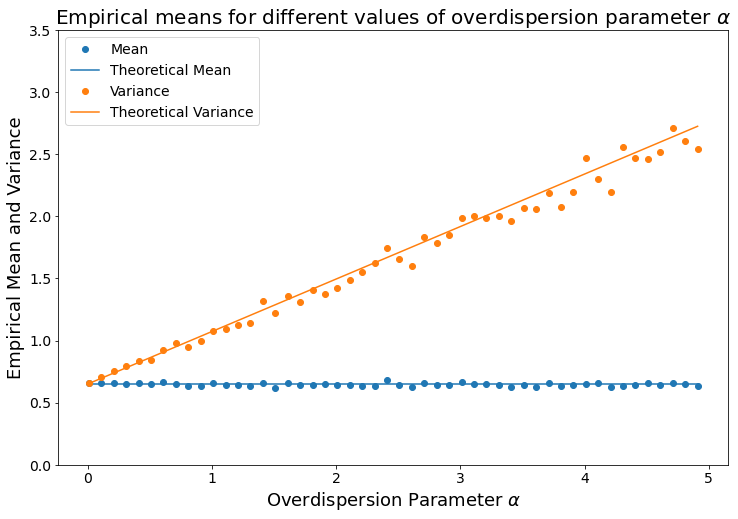

In [6]:
def poisson_gamma_mixture_mean(lambd, alpha, size=10000):
    """MCMC'ed mean of Poisson-Gamma mixture.
    
    Parameters
    ----------
    lambd : float
        np.exp(beta * X)
    alpha : float
        Gamma overdispersion parameter.
    size : int, optional
        Sample size for calculating empirical mean. Default: 10000.
    """

    # Scipy's Gamma RV is weirdly defined, so use Numpy's, where k = nu and theta = 1 / eta (SEE ADDENDUM BELOW)
    # https://numpy.org/doc/stable/reference/random/generated/numpy.random.gamma.html?highlight=gamma
    # The mean is k * theta = 1, while the variance is given by k * theta^2.
    # nu = 1 / alpha, so theta = alpha, which makes the variance alpha.
    gamma_draws = np.random.gamma(1. / alpha, alpha, size=size)
    poisson_mixture_draws = np.random.poisson(lam=(lambd * gamma_draws))
    return poisson_mixture_draws.mean(), poisson_mixture_draws.var()

    # Addendum - Scipy's Gamma RV is actually identically defined to Numpy's. To sample, use
    # sps.gamma.rvs(a=(1. / alpha), scale=alpha, size=size)

want_mean = 0.65

alphas = np.arange(0.01, 5, 0.1)
pgm_sumstats = np.array([poisson_gamma_mixture_mean(want_mean, alpha) for alpha in alphas])

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(alphas, pgm_sumstats[:, 0], marker='o', ls='None', color=mpl_def_colors[0], label='Mean')
ax.plot(alphas, want_mean * np.ones_like(alphas), marker='None', ls='-', color=colors[0], label='Theoretical Mean')
ax.plot(alphas, pgm_sumstats[:, 1], marker='o', ls='None', color=mpl_def_colors[1], label='Variance')
ax.plot(alphas, alphas * want_mean**2 + want_mean, marker='None', ls='-', color=colors[1], label='Theoretical Variance')
ax.set_xlabel(r'Overdispersion Parameter $\alpha$', fontsize=18)
ax.set_ylabel('Empirical Mean and Variance', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_ylim([0, 3.5])
ax.set_title(r"Empirical means for different values of overdispersion parameter $\alpha$", fontsize=20)
ax.legend(loc=2, fontsize=14);

This is a great confirmation! So we can now confirm the mean depends only on the *deterministic* component $\lambda_i = \exp(\vec{\beta}\cdot\vec{X}_i)$, while the variance is given by $\lambda_i + \alpha \lambda_i^2$ in the NB2 formulation. This is why so many of these documents are flippant about using $\mu$ and $\lambda$ interchangeably.

## 10.5 - Zero-Inflated Poisson and Negative Binomial Regression Models

Zero-inflated versions of Poisson and negative binomial are useful when there is a distinct zero-state to the system on top of the "normal-state" of Poisson or negative binomial.  This can be absolutely zero (eg. a commuter may not take public transit today, or may never take public transit - the two states both have zero value, but are distinct) or effectively zero (eg. multilane highways have very, very few pedestrian collisions).  If we were to treat the zero-state and normal-state with only a normal-state distribution, we'd find the data overdispersed.

The zero-inflated Poisson model is

$$
y_i = \begin{cases}0,\,\,P = p_i + (1 - p_i)\exp{(-\lambda_i)} \\ y,\,\,P = (1 - p_i)\frac{\exp{(-\lambda_i)\lambda_i^y}}{y!} \end{cases}
$$

If we define $f_\mathrm{Poisson}$ as the PMF of the Poisson distribution, we can rewrite the above as

$$
y_i = \begin{cases}0,\,\,P = p_i + (1 - p_i)f_\mathrm{Poisson}(0) \\ y,\,\,P = (1 - p_i)f_\mathrm{Poisson}(y) \end{cases}
$$

The zero-inflated negative binomial model has the same formulation, which I'll simplify by defining $f_\mathrm{NB}$ as the PMF of the negative binomial distribution.

$$
y_i = \begin{cases}0,\,\,P = p_i + (1 - p_i)f_\mathrm{NB}(0) \\ y,\,\,P = (1 - p_i)f_\mathrm{NB}(y) \end{cases}
$$

The probability $p_i$ governs whether the endogenous variable is zero-state or normal-state.

To test whether the zero-inflated Poisson or negative binomial should be used over a traditional model, we can calculate the natural-log of the ratio between the zero-inflated probability mass function and traditional PMF:

$$
m_i = \ln\left(\frac{f_1(y_i|\vec{X}_i)}{f_2(y_i|\vec{X}_i)}\right)
$$

This value can then transformed into the [Vuong](https://en.wikipedia.org/wiki/Vuong%27s_closeness_test) test statistic $V$ ([Python implementation](https://gist.github.com/jseabold/6617976#file-zip_model-py-L5)), which is asymptotically normally distributed.  If $V > \alpha$ (usually $1.96$ for 2-sigma), model 1 is favoured over 2, and if $V < -\alpha$ the opposite is true.  If $|V| < \alpha$ the test is inconclusive.  Because it's often difficult to distinguish between a true overdispersion and a two-state split (both inflate the variance), the Vuong test can assist with model selection.  See Table 10.5 of Washington (which itself comes from Shankar et al. 1997) for model selection guidelines.

## Addendum: Statsmodels Count Regression Models

### Negative Binomial Regression

Statsmodels's [negative binomial class](https://www.statsmodels.org/devel/_modules/statsmodels/discrete/discrete_model.html#NegativeBinomial) by default uses `loglike_method='nb2'`. When `self.loglike` is called, it uses `self._ll_nb2` to calculate the log-likelihood, which in turn calls `self._ll_nbin`. The latter is defined as:

```python
    def _ll_nbin(self, params, alpha, Q=0):
        if np.any(np.iscomplex(params)) or np.iscomplex(alpha):
            gamma_ln = loggamma
        else:
            # scipy.special.gammaln, the natural log of Gamma_function(x).
            gamma_ln = gammaln
        endog = self.endog
        # Returns the exp of linear predictor exp(dot(exog,params)).
        mu = self.predict(params)
        # Just nu - mu**Q is an array of ones because Q == 0.
        size = 1/alpha * mu**Q
        # NB prob of success (see above).
        prob = size/(size+mu)
        coeff = (gamma_ln(size+endog) - gamma_ln(endog+1) -
                 gamma_ln(size))
        llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
        return llf
```

The last two lines are equivalent to Eqn. 8.10 of Hilbe. Notably, `mu` is $\lambda = \exp(\vec{\beta}\cdot\vec{X})$.

### Example: Modeling of Number of Marital Affairs

We practice visualizing best fit results by trying Poisson and NB fits on the classic Fair affairs dataset.

In [10]:
# Data and dictionary at http://pages.stern.nyu.edu/~wgreene/Text/tables/tablelist5.htm
# More info here https://rdrr.io/cran/AER/man/Affairs.html (note that the "number" of affairs is
# pretty weirdly binned).
if os.path.exists("./fair_affairs.hdf"):
    affairs = pd.read_hdf("./fair_affairs.hdf", "table")
else:
    affairs = pd.read_csv("http://people.stern.nyu.edu/wgreene/Text/tables/TableF22-2.txt", header=0, delimiter=r"\s+")
    affairs.drop(columns=['ID', 'X1', 'X2', 'X3', 'X4', 'X5'], inplace=True)
    affairs.columns = ['Sex', 'Age', 'Number of years married', 'Children',
                       'Religiousness', 'Education', 'Occupation', 'Self-rating of marriage',
                       'Number of affairs']
    affairs.to_hdf("./fair_affairs.hdf", "table")

In [11]:
affairs.head()

,Sex,Age,Number of years married,Children,Religiousness,Education,Occupation,Self-rating of marriage,Number of affairs
0,1,37.0,10.00,0,3,18.0,7,4,0.0
1,0,27.0,4.00,0,4,14.0,6,4,0.0
2,0,32.0,15.00,1,1,12.0,1,4,0.0
3,1,57.0,15.00,1,5,18.0,6,5,0.0
4,1,22.0,0.75,0,2,17.0,6,3,0.0


Reproducing Table 9.23 of Hilbe:

In [ ]:
# affairs_exog['vryunhp'] = (affairs['Self-rating of marriage'] == 1).astype(int)
# affairs_exog['unhap'] = (affairs['Self-rating of marriage'] == 2).astype(int)
# affairs_exog['avgmarr'] = (affairs['Self-rating of marriage'] == 3).astype(int)
# affairs_exog['hapavg'] = (affairs['Self-rating of marriage'] == 4).astype(int)
# affairs_exog['vryhap'] = (affairs['Self-rating of marriage'] == 5).astype(int)
# affairs_exog['antirel'] = (affairs['Religiousness'] == 1).astype(int)
# affairs_exog['notrel'] = (affairs['Religiousness'] == 2).astype(int)
# affairs_exog['slghtrel'] = (affairs['Religiousness'] == 3).astype(int)
# affairs_exog['smerel'] = (affairs['Religiousness'] == 4).astype(int)
# affairs_exog['vryrel'] = (affairs['Religiousness'] == 5).astype(int)
# affairs_exog['yrsmarr1'] = (affairs['Number of years married'] == 0.75).astype(int)
# affairs_exog['yrsmarr2'] = (affairs['Number of years married'] == 1.5).astype(int)
# affairs_exog['yrsmarr3'] = (affairs['Number of years married'] == 4.).astype(int)
# affairs_exog['yrsmarr4'] = (affairs['Number of years married'] == 7.).astype(int)
# affairs_exog['yrsmarr5'] = (affairs['Number of years married'] == 10.).astype(int)
# affairs_exog['yrsmarr6'] = (affairs['Number of years married'] == 15.).astype(int)

Let's start with a Poisson regression.

I kept getting NaNs fitting a Poisson to all the above variables, so used the exact variables in 9.25.

In [19]:
# Somewhat absurd one-hot encoding, but will follow .
affairs_exog = pd.DataFrame(affairs['Children'].values, columns=['kids',])
affairs_exog['avgmarr'] = (affairs['Self-rating of marriage'] == 3).astype(int)
affairs_exog['hapavg'] = (affairs['Self-rating of marriage'] == 4).astype(int)
affairs_exog['vryhap'] = (affairs['Self-rating of marriage'] == 5).astype(int)
affairs_exog['notrel'] = (affairs['Religiousness'] == 2).astype(int)
affairs_exog['slghtrel'] = (affairs['Religiousness'] == 3).astype(int)
affairs_exog['smerel'] = (affairs['Religiousness'] == 4).astype(int)
affairs_exog['vryrel'] = (affairs['Religiousness'] == 5).astype(int)
affairs_exog['yrsmarr3'] = (affairs['Number of years married'] == 4.).astype(int)
affairs_exog['yrsmarr4'] = (affairs['Number of years married'] == 7.).astype(int)
affairs_exog['yrsmarr5'] = (affairs['Number of years married'] == 10.).astype(int)
affairs_exog['yrsmarr6'] = (affairs['Number of years married'] == 15.).astype(int)

In [13]:
model = sm.Poisson(endog=affairs[['Number of affairs']],
                            exog=sm.add_constant(affairs_exog))
results = model.fit(method='lbfgs',
                    maxiter=100)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:      Number of affairs   No. Observations:                  601
Model:                        Poisson   Df Residuals:                      588
Method:                           MLE   Df Model:                           12
Date:                Thu, 07 May 2020   Pseudo R-squ.:                  0.1812
Time:                        23:21:38   Log-Likelihood:                -1399.9
converged:                       True   LL-Null:                       -1709.7
Covariance Type:            nonrobust   LLR p-value:                6.835e-125
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1016      0.165      6.683      0.000       0.779       1.425
kids          -0.2227      0.106     -2.101      0.036      -0.430      -0.015
avgmarr       -0.8858      0.105     -8.434      0.000      -1.092      -0.680
hapavg        -1.0239      0.086    -11.916      0.000      -1.192      -0.855
vryhap        -1.3838      0.101    -13.707      0.000      -1.582      -1.186
notrel        -0.6554      0.111     -5.894      0.000      -0.873      -0.437
slghtrel      -0.5237      0.111     -4.704      0.000      -0.742      -0.306
smerel        -1.3707      0.121    -11.300      0.000      -1.608      -1.133
vryrel        -1.3638      0.159     -8.579      0.000      -1.675      -1.052
yrsmarr3       0.7578      0.161      4.701      0.000       0.442       1.074
yrsmarr4       1.1046      0.170      6.502      0.000       0.772       1.438
yrsmarr5       1.4804      0.165      8.979      0.000       1.157       1.804
yrsmarr6       1.4805      0.156      9.515      0.000       1.176       1.785
==============================================================================
"""

These coefficients are identical to Hilbe's Poisson fit in 9.25.

Hilbe Fig. 9.1 is a plot of the PMF of the observed number of affairs alongside the PMF of the best fit model. In [Hilbe's COUNT R library](https://cran.r-project.org/web/packages/COUNT/index.html), the PMF is estimated by determining $f(y|\lambda)$ for the $\lambda$ of every single data point, then averaging these. This is effectively an independent variable-weighted mean PMF (which should also preserve the normalization, since the weights are the same regardless of the value of $y$), an estimate of the *unconditional probability distribution for $y$*. The development version of statsmodels does something very similar if you use `results.predict(which="pmf")`, but since I'm on 0.11, I'll have to code it manually.

In [35]:
# Double-check that results is just np.exp(beta * X), where X needs to include a constant.
assert np.allclose(results.predict(),
                   np.exp(sm.add_constant(affairs_exog)
                          .values.dot(results.params.values)))

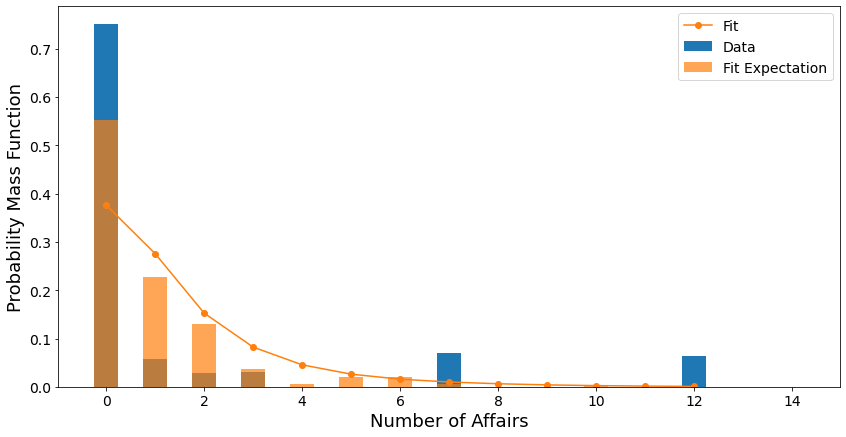

In [69]:
def get_poisson_fit_pmf(endog, results):
    # Based off of statsmodels Negative Binomial Predict
    # https://www.statsmodels.org/devel/generated/statsmodels.discrete.discrete_model.NegativeBinomialP.predict.html#statsmodels.discrete.count_model.NegativeBinomialP.predict
    counts = np.atleast_2d(np.arange(0, endog.max() + 1))
    lambd = results.predict()
    return counts.ravel(), sps.poisson.pmf(counts, lambd[:, None]).mean(axis=0)

fit_counts, fit_pmf = get_poisson_fit_pmf(affairs['Number of affairs'], results)

fig, ax = plt.subplots(figsize=(14, 7))
ax.hist(affairs['Number of affairs'], bins=np.arange(16), label='Data',
        rwidth=0.5, align='left', color=mpl_def_colors[0], density=True)
ax.hist(results.predict(), bins=np.arange(16), label='Fit Expectation',
        rwidth=0.5, align='left', color=mpl_def_colors[1], density=True, alpha=0.7)
ax.plot(fit_counts, fit_pmf, ls='-', marker='o', color=mpl_def_colors[1], label='Fit')
ax.set_xlabel('Number of Affairs', fontsize=18)
ax.set_ylabel('Probability Mass Function', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(loc=1, fontsize=14);

The appropriate comparison is between the fit PMF and the estimated PMF from the observed values.

Plotting the fit expectation here is somewhat nonsensical - the closest equivalent in ordinary least-squares regression would be to plot the distribution of the dependent variable against the distribution of values obtained by passing the independent variables through the best fit model. Except that for OLS the noise is not inherently coupled to the signal (like it is for Poisson regression where the mean and standard deviation take on the same value). So, very loosely speaking, plotting the fit expectation only shows how much the expected value changes due to changes in the independent variables (if the distribution is dominated by "signal").

Now let's try negative binomial regression.

In [91]:
model = sm.NegativeBinomial(endog=affairs[['Number of affairs']],
                            exog=affairs_exog, loglike_method='nb2')
results = model.fit(method='lbfgs', maxiter=100)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:      Number of affairs   No. Observations:                  601
Model:               NegativeBinomial   Df Residuals:                      589
Method:                           MLE   Df Model:                           11
Date:                Fri, 08 May 2020   Pseudo R-squ.:                 0.03466
Time:                        00:39:05   Log-Likelihood:                -725.14
converged:                       True   LL-Null:                       -751.17
Covariance Type:            nonrobust   LLR p-value:                 2.645e-07
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
kids           0.1889      0.294      0.642      0.521      -0.388       0.766
avgmarr       -0.6964      0.368     -1.893      0.058      -1.417       0.025
hapavg        -0.7824      0.321     -2.434      0.015      -1.413      -0.152
vryhap        -1.0978      0.292     -3.763      0.000      -1.670      -0.526
notrel         0.0989      0.336      0.294      0.769      -0.560       0.757
slghtrel      -0.0357      0.366     -0.098      0.922      -0.753       0.681
smerel        -1.1386      0.366     -3.109      0.002      -1.856      -0.421
vryrel        -1.1823      0.465     -2.544      0.011      -2.093      -0.271
yrsmarr3       0.8965      0.354      2.531      0.011       0.202       1.591
yrsmarr4       1.5544      0.413      3.762      0.000       0.745       2.364
yrsmarr5       1.3551      0.425      3.186      0.001       0.522       2.189
yrsmarr6       1.6571      0.342      4.849      0.000       0.987       2.327
alpha          6.8485      0.766      8.937      0.000       5.347       8.350
==============================================================================
"""

Not sure at all why I can't reproduce Table 9.27, but the plot is very similar.

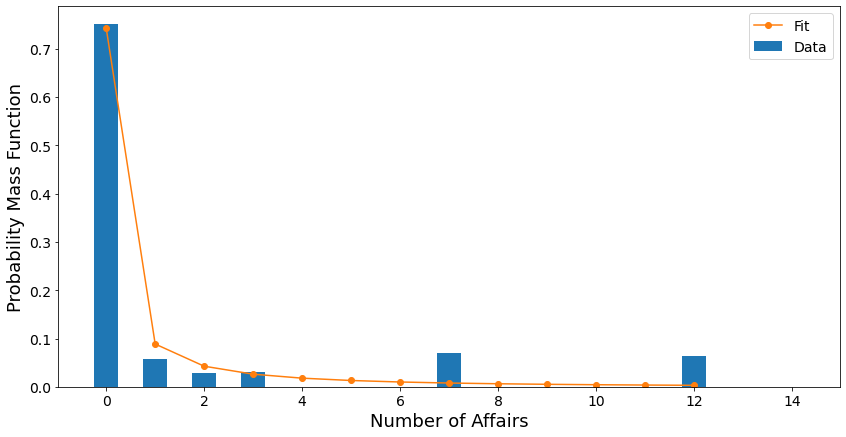

In [98]:
def get_nb2_fit_pmf(endog, results):
    # Based off of statsmodels Negative Binomial Predict
    # https://www.statsmodels.org/devel/generated/statsmodels.discrete.discrete_model.NegativeBinomialP.predict.html#statsmodels.discrete.count_model.NegativeBinomialP.predict
    counts = np.atleast_2d(np.arange(0, endog.max() + 1))
    mu = results.predict()
    size = 1. / results.params[-1]
    prob = size / (size + mu)
    size = size * np.ones_like(prob)
    return counts.ravel(), sps.nbinom.pmf(counts, size[:,None], prob[:,None]).mean(axis=0)

fit_counts, fit_pmf = get_nb2_fit_pmf(affairs['Number of affairs'], results)

fig, ax = plt.subplots(figsize=(14, 7))
ax.hist(affairs['Number of affairs'], bins=np.arange(16), label='Data',
        rwidth=0.5, align='left', color=mpl_def_colors[0], density=True)
ax.plot(fit_counts, fit_pmf, ls='-', marker='o', color=mpl_def_colors[1], label='Fit')
ax.set_xlabel('Number of Affairs', fontsize=18)
ax.set_ylabel('Probability Mass Function', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(loc=1, fontsize=14);

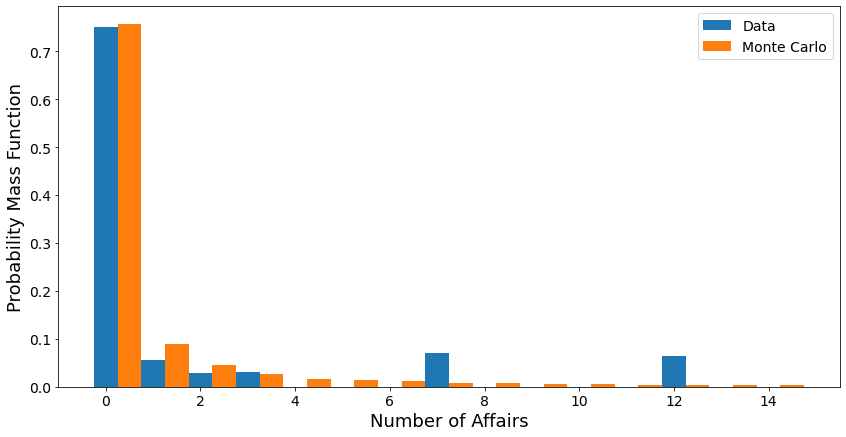

In [99]:
def get_nb2_fit_mc(results, size=10000):
    # Bootstrapped lambda.
    lambd_draws = np.random.choice(results.predict(), replace=True,
                                   size=size)
    gamma_draws = np.random.gamma(1. / results.params[-1],
                                  results.params[-1], size=size)
    return np.random.poisson(lam=(lambd_draws * gamma_draws))

fit_mc = get_nb2_fit_mc(results)

fig, ax = plt.subplots(figsize=(14, 7))
ax.hist(affairs['Number of affairs'], bins=np.arange(16), label='Data',
        rwidth=0.5, align='left', color=mpl_def_colors[0], density=True)
ax.hist(fit_mc, bins=np.arange(16), label='Monte Carlo',
        rwidth=0.5, align='mid', color=mpl_def_colors[1], density=True)
ax.set_xlabel('Number of Affairs', fontsize=18)
ax.set_ylabel('Probability Mass Function', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(loc=1, fontsize=14);